# Multiclass Neural Networks: Customer Purchase Behavior Classification

In [1]:
# Extending from binary to multiclass prediction using PyTorch

import torch  # Import PyTorch for neural network operations
import torch.nn as nn  # Import neural network modules from PyTorch
import matplotlib.pyplot as plt  # Import matplotlib for plotting and visualization
import numpy as np  # Import numpy for numerical operations
from torch.utils.data import Dataset, DataLoader  # Import data handling utilities
import torch.nn.functional as F  # Import functional interface for neural network operations

torch.manual_seed(42)  # Ensure reproducible results across experiments

In [2]:
# =============================================================================
# Multiclass Customer Dataset (4 Categories Instead of Binary)
# =============================================================================

class MulticlassCustomerDataset(Dataset):  # Custom dataset class for multiclass customer behavior patterns
    """Create multiclass customer behavior dataset with 4 purchase categories"""
    
    def __init__(self, num_samples=1000):  # Constructor to initialize dataset with specified number of samples
        self.len = num_samples  # Store the total number of samples in the dataset
        
        # Define 4 classes for customer behavior:
        # Class 0: No Purchase (low engagement, short time)
        # Class 1: Window Shopping (high engagement, short time) 
        # Class 2: Research Purchase (low engagement, long time)
        # Class 3: Impulse Purchase (high engagement, long time)
        
        self.browsing_time = torch.zeros((num_samples, 2))  # Initialize tensor for 2D input features (time, engagement)
        self.purchase_category = torch.zeros(num_samples, dtype=torch.long)  # Initialize tensor for class labels (4 categories)
        
        samples_per_class = num_samples // 4  # Calculate how many samples per class (divide by 4 classes)
        
        for i in range(samples_per_class):  # Loop through samples for each class
            # Class 0: No Purchase (low time, low engagement)
            self.browsing_time[i, :] = torch.tensor([0.3, 0.3]) + 0.2 * torch.randn(2)  # Low time and engagement with noise
            self.purchase_category[i] = 0  # Set label to class 0
            
            # Class 1: Window Shopping (low time, high engagement)
            self.browsing_time[i + samples_per_class, :] = torch.tensor([0.3, 0.8]) + 0.2 * torch.randn(2)  # Low time, high engagement
            self.purchase_category[i + samples_per_class] = 1  # Set label to class 1
            
            # Class 2: Research Purchase (high time, low engagement)
            self.browsing_time[i + 2*samples_per_class, :] = torch.tensor([0.8, 0.3]) + 0.2 * torch.randn(2)  # High time, low engagement
            self.purchase_category[i + 2*samples_per_class] = 2  # Set label to class 2
            
            # Class 3: Impulse Purchase (high time, high engagement)
            self.browsing_time[i + 3*samples_per_class, :] = torch.tensor([0.8, 0.8]) + 0.2 * torch.randn(2)  # High time and engagement
            self.purchase_category[i + 3*samples_per_class] = 3  # Set label to class 3
    
    def __getitem__(self, index):  # Required method to get a single sample by index
        return self.browsing_time[index], self.purchase_category[index]  # Return feature-label pair for given index
    
    def __len__(self):  # Required method to return dataset size
        return self.len  # Return total number of samples


In [3]:
# =============================================================================
# Multiclass Neural Network Using nn.Module (Following Transcript Architecture)
# =============================================================================

class MulticlassCustomerNet(nn.Module):  # Neural network class for multiclass customer behavior prediction
    """Multiclass neural network with 4 output neurons for 4 customer categories"""
    
    def __init__(self, d_in, h, d_out):  # Network architecture definition (following transcript naming)
        super(MulticlassCustomerNet, self).__init__()  # Initialize parent class
        
        # Hidden layer with h neurons
        self.linear1 = nn.Linear(d_in, h)  # First linear layer (input to hidden)
        
        # Output layer with d_out neurons (one per class)
        self.linear2 = nn.Linear(h, d_out)  # Second linear layer (hidden to output)
    
    def forward(self, x):  # Forward pass through network
        x = torch.relu(self.linear1(x))  # Apply ReLU activation to hidden layer
        x = self.linear2(x)  # Apply linear transformation to output (NO activation here!)
        return x  # Return raw logits (scores) for each class


In [4]:
# =============================================================================
# Alternative: Multiclass Neural Network Using nn.Sequential
# =============================================================================

def create_multiclass_sequential_model(input_dim, hidden_dim, output_dim):  # Function to create Sequential multiclass model
    """Create multiclass neural network using nn.Sequential for comparison"""
    
    model = nn.Sequential(  # Sequential container chains operations
        nn.Linear(input_dim, hidden_dim),  # Input to hidden linear layer
        nn.ReLU(),  # ReLU activation function
        nn.Linear(hidden_dim, output_dim)  # Hidden to output linear layer (NO Softmax!)
    )
    
    return model  # Return complete sequential model


In [5]:
# =============================================================================
# Training Function with Multiclass Accuracy Calculation
# =============================================================================

def train_multiclass_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):  # Training with multiclass accuracy tracking
    """Train multiclass model and track performance metrics"""
    
    train_losses = []  # Track training loss over epochs
    val_accuracies = []  # Track validation accuracy over epochs
    
    for epoch in range(num_epochs):  # Loop through training epochs
        # Training phase
        model.train()  # Set model to training mode
        epoch_loss = 0.0  # Accumulate training loss for current epoch
        
        for batch_x, batch_y in train_loader:  # Process training batches
            optimizer.zero_grad()  # Clear gradients from previous iteration
            
            # Forward pass: get model predictions (logits)
            predictions = model(batch_x)  # Model predictions for current batch (raw scores)
            
            # Calculate loss using CrossEntropyLoss (applies Softmax internally)
            loss = criterion(predictions, batch_y)  # CrossEntropy loss for multiclass classification
            
            # Backward pass: compute gradients
            loss.backward()  # Backpropagate error through network
            
            # Update parameters
            optimizer.step()  # Apply computed gradients
            
            epoch_loss += loss.item()  # Accumulate loss for this batch
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        correct_predictions = 0  # Count correct predictions
        total_samples = 0  # Count total samples
        
        with torch.no_grad():  # Disable gradient computation for validation
            for val_x, val_y in val_loader:  # Process validation batches
                val_predictions = model(val_x)  # Get validation predictions (logits)
                
                # Convert logits to class predictions using argmax
                predicted_classes = torch.argmax(val_predictions, dim=1)  # Get class with highest score
                
                # Calculate accuracy
                correct_predictions += (predicted_classes == val_y).sum().item()  # Count correct predictions
                total_samples += val_y.size(0)  # Count total samples
        
        # Calculate metrics for this epoch
        avg_loss = epoch_loss / len(train_loader)  # Average loss per batch
        val_accuracy = correct_predictions / total_samples  # Validation accuracy
        
        train_losses.append(avg_loss)  # Store training loss
        val_accuracies.append(val_accuracy)  # Store validation accuracy
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:  # Progress reporting
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    return train_losses, val_accuracies  # Return training metrics


In [6]:
# =============================================================================
# Multiclass Decision Boundary Visualization
# =============================================================================

def plot_multiclass_decision_regions(model, dataset, title):  # Function to visualize multiclass decision boundaries
    """Plot decision regions for multiclass customer behavior prediction"""
    
    # Define colors for 4 classes
    colors = ['red', 'blue', 'green', 'orange']  # Colors for each class
    class_names = ['No Purchase', 'Window Shopping', 'Research Purchase', 'Impulse Purchase']  # Class names
    
    X = dataset.browsing_time.numpy()  # Convert features to numpy array for plotting
    y = dataset.purchase_category.numpy()  # Convert labels to numpy array for plotting
    
    h = 0.02  # Set step size for meshgrid (smaller = more detailed decision boundary)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1  # Calculate x-axis bounds with padding
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1  # Calculate y-axis bounds with padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Create coordinate grid for decision boundary
    
    XX = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)  # Convert grid to tensor for model input
    
    with torch.no_grad():  # Disable gradients for inference
        logits = model(XX)  # Get model predictions on grid (logits)
        predicted_classes = torch.argmax(logits, dim=1).numpy().reshape(xx.shape)  # Convert to class predictions
    
    # Plot decision regions
    plt.figure(figsize=(12, 8))  # Create figure with specified size
    
    # Create custom colormap for decision regions
    from matplotlib.colors import ListedColormap  # Import color mapping
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA', '#FFDDAA'])  # Light colors for regions
    
    plt.pcolormesh(xx, yy, predicted_classes, cmap=cmap_light, alpha=0.8)  # Plot decision regions as colored mesh
    
    # Plot data points for each class
    for class_idx in range(4):  # Loop through each class
        mask = y == class_idx  # Create mask for current class
        plt.scatter(X[mask, 0], X[mask, 1], c=colors[class_idx], 
                   label=class_names[class_idx], alpha=0.7, s=50, edgecolors='black')  # Plot class points
    
    plt.xlabel('Browsing Time (normalized)')  # Set x-axis label
    plt.ylabel('Engagement Level (normalized)')  # Set y-axis label
    plt.title(title)  # Set plot title
    plt.legend()  # Show legend for classes
    plt.grid(True, alpha=0.3)  # Add grid with transparency
    plt.show()  # Display the plot


In [7]:
# =============================================================================
# Experiment: Compare Binary vs Multiclass Classification
# =============================================================================

print("=== Multiclass Neural Networks: Customer Behavior Classification ===")

# Create multiclass dataset
multiclass_dataset = MulticlassCustomerDataset(num_samples=800)  # Create dataset with 800 samples
print(f"Created multiclass dataset with {len(multiclass_dataset)} samples")
print(f"Number of classes: 4 (No Purchase, Window Shopping, Research Purchase, Impulse Purchase)")

# Split into train and validation
train_size = int(0.7 * len(multiclass_dataset))  # 70% for training
val_size = len(multiclass_dataset) - train_size  # 30% for validation

train_dataset, val_dataset = torch.utils.data.random_split(multiclass_dataset, [train_size, val_size])  # Split dataset

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Training data loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Validation data loader

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Model hyperparameters (following transcript conventions)
d_in = 2  # Number of input features (browsing time, engagement)
h = 8  # Hidden layer size
d_out = 4  # Number of output classes
num_epochs = 100  # Training epochs
learning_rate = 0.01  # Learning rate

print(f"\nModel architecture: {d_in} -> {h} -> {d_out}")


=== Multiclass Neural Networks: Customer Behavior Classification ===
Created multiclass dataset with 800 samples
Number of classes: 4 (No Purchase, Window Shopping, Research Purchase, Impulse Purchase)
Training samples: 560
Validation samples: 240

Model architecture: 2 -> 8 -> 4


In [8]:
# =============================================================================
# Train nn.Module Model
# =============================================================================

print(f"\n--- Training Multiclass Model using nn.Module ---")

# Create model using nn.Module approach
module_model = MulticlassCustomerNet(d_in, h, d_out)  # Create multiclass model

# Define loss and optimizer for multiclass classification
criterion = nn.CrossEntropyLoss()  # CrossEntropy loss (includes Softmax internally)
optimizer = torch.optim.Adam(module_model.parameters(), lr=learning_rate)  # Adam optimizer

# Train the model
module_losses, module_accuracies = train_multiclass_model(  # Train and track metrics
    module_model, train_loader, val_loader, criterion, optimizer, num_epochs
)

print(f"nn.Module model final accuracy: {module_accuracies[-1]:.4f} ({module_accuracies[-1]*100:.2f}%)")



--- Training Multiclass Model using nn.Module ---
Epoch [20/100], Loss: 0.4691, Val Accuracy: 0.8000
Epoch [40/100], Loss: 0.4641, Val Accuracy: 0.7917
Epoch [60/100], Loss: 0.4658, Val Accuracy: 0.8125
Epoch [80/100], Loss: 0.4598, Val Accuracy: 0.8000
Epoch [100/100], Loss: 0.4653, Val Accuracy: 0.7958
nn.Module model final accuracy: 0.7958 (79.58%)


In [9]:
# =============================================================================
# Train nn.Sequential Model
# =============================================================================

print(f"\n--- Training Multiclass Model using nn.Sequential ---")

# Create model using nn.Sequential approach
sequential_model = create_multiclass_sequential_model(d_in, h, d_out)  # Create sequential multiclass model

# Use same loss and optimizer setup
criterion_seq = nn.CrossEntropyLoss()  # CrossEntropy loss for sequential model
optimizer_seq = torch.optim.Adam(sequential_model.parameters(), lr=learning_rate)  # Adam optimizer for sequential

# Train the sequential model
sequential_losses, sequential_accuracies = train_multiclass_model(  # Train sequential model
    sequential_model, train_loader, val_loader, criterion_seq, optimizer_seq, num_epochs
)

print(f"nn.Sequential model final accuracy: {sequential_accuracies[-1]:.4f} ({sequential_accuracies[-1]*100:.2f}%)")



--- Training Multiclass Model using nn.Sequential ---
Epoch [20/100], Loss: 0.4605, Val Accuracy: 0.8042
Epoch [40/100], Loss: 0.4708, Val Accuracy: 0.8000
Epoch [60/100], Loss: 0.4601, Val Accuracy: 0.8042
Epoch [80/100], Loss: 0.4601, Val Accuracy: 0.8083
Epoch [100/100], Loss: 0.4524, Val Accuracy: 0.8083
nn.Sequential model final accuracy: 0.8083 (80.83%)


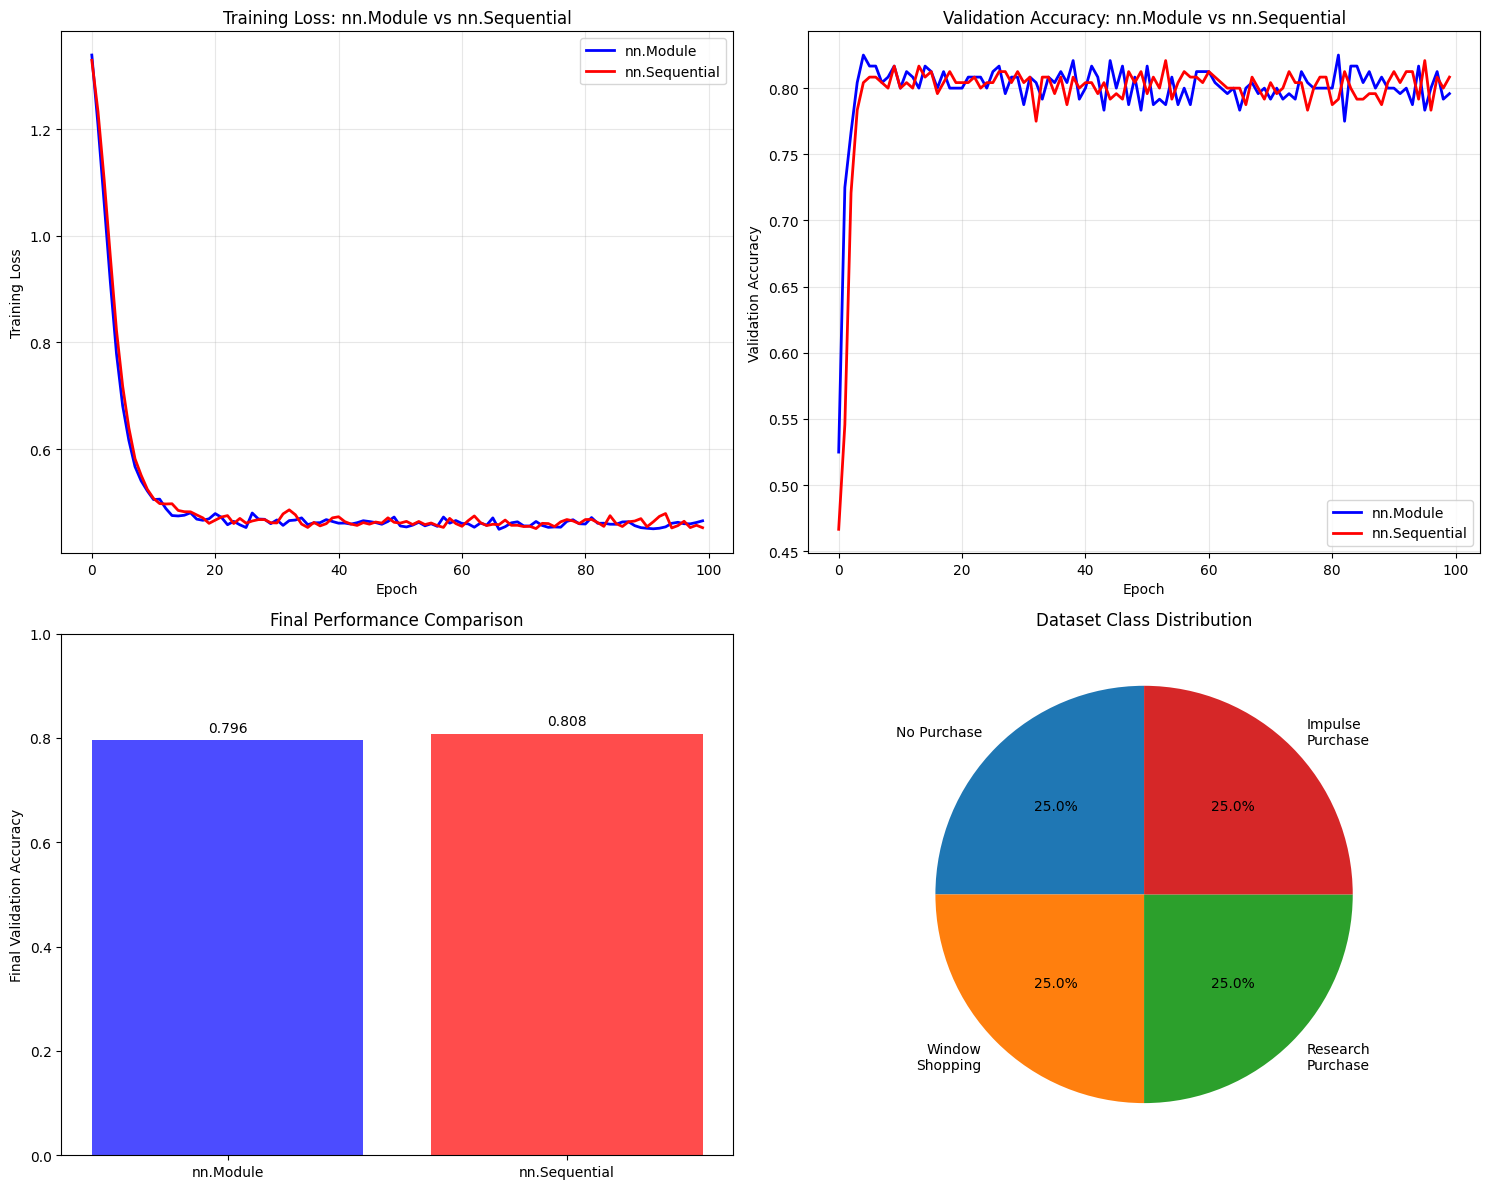

In [10]:
# =============================================================================
# Analyze and Visualize Multiclass Results
# =============================================================================

def plot_multiclass_training_analysis(module_results, sequential_results):  # Comprehensive multiclass analysis
    """Plot comprehensive analysis of multiclass training results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Create 2x2 subplot grid
    
    # Plot 1: Training Loss Comparison
    ax1 = axes[0, 0]  # Top-left subplot
    ax1.plot(module_results['losses'], label='nn.Module', linewidth=2, color='blue')  # Module model loss
    ax1.plot(sequential_results['losses'], label='nn.Sequential', linewidth=2, color='red')  # Sequential model loss
    ax1.set_xlabel('Epoch')  # X-axis label
    ax1.set_ylabel('Training Loss')  # Y-axis label
    ax1.set_title('Training Loss: nn.Module vs nn.Sequential')  # Plot title
    ax1.legend()  # Show legend
    ax1.grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Validation Accuracy Comparison
    ax2 = axes[0, 1]  # Top-right subplot
    ax2.plot(module_results['accuracies'], label='nn.Module', linewidth=2, color='blue')  # Module model accuracy
    ax2.plot(sequential_results['accuracies'], label='nn.Sequential', linewidth=2, color='red')  # Sequential model accuracy
    ax2.set_xlabel('Epoch')  # X-axis label
    ax2.set_ylabel('Validation Accuracy')  # Y-axis label
    ax2.set_title('Validation Accuracy: nn.Module vs nn.Sequential')  # Plot title
    ax2.legend()  # Show legend
    ax2.grid(True, alpha=0.3)  # Add grid
    
    # Plot 3: Final Performance Comparison
    ax3 = axes[1, 0]  # Bottom-left subplot
    models = ['nn.Module', 'nn.Sequential']  # Model names
    final_accuracies = [module_results['accuracies'][-1], sequential_results['accuracies'][-1]]  # Final accuracies
    
    bars = ax3.bar(models, final_accuracies, color=['blue', 'red'], alpha=0.7)  # Bar chart
    ax3.set_ylabel('Final Validation Accuracy')  # Y-axis label
    ax3.set_title('Final Performance Comparison')  # Plot title
    ax3.set_ylim(0, 1)  # Set y-axis limits
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, final_accuracies):  # Add accuracy labels
        height = bar.get_height()  # Get bar height
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Position text
                f'{accuracy:.3f}', ha='center', va='bottom')  # Format text
    
    # Plot 4: Class Distribution
    ax4 = axes[1, 1]  # Bottom-right subplot
    class_names = ['No Purchase', 'Window\nShopping', 'Research\nPurchase', 'Impulse\nPurchase']  # Class names
    class_counts = [200, 200, 200, 200]  # Equal distribution (samples_per_class)
    
    ax4.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)  # Pie chart
    ax4.set_title('Dataset Class Distribution')  # Plot title
    
    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display plots

# Store results for analysis
module_results = {'losses': module_losses, 'accuracies': module_accuracies}  # Store module model results
sequential_results = {'losses': sequential_losses, 'accuracies': sequential_accuracies}  # Store sequential model results

# Generate training analysis
plot_multiclass_training_analysis(module_results, sequential_results)  # Create training analysis



=== Visualizing Multiclass Decision Boundaries ===


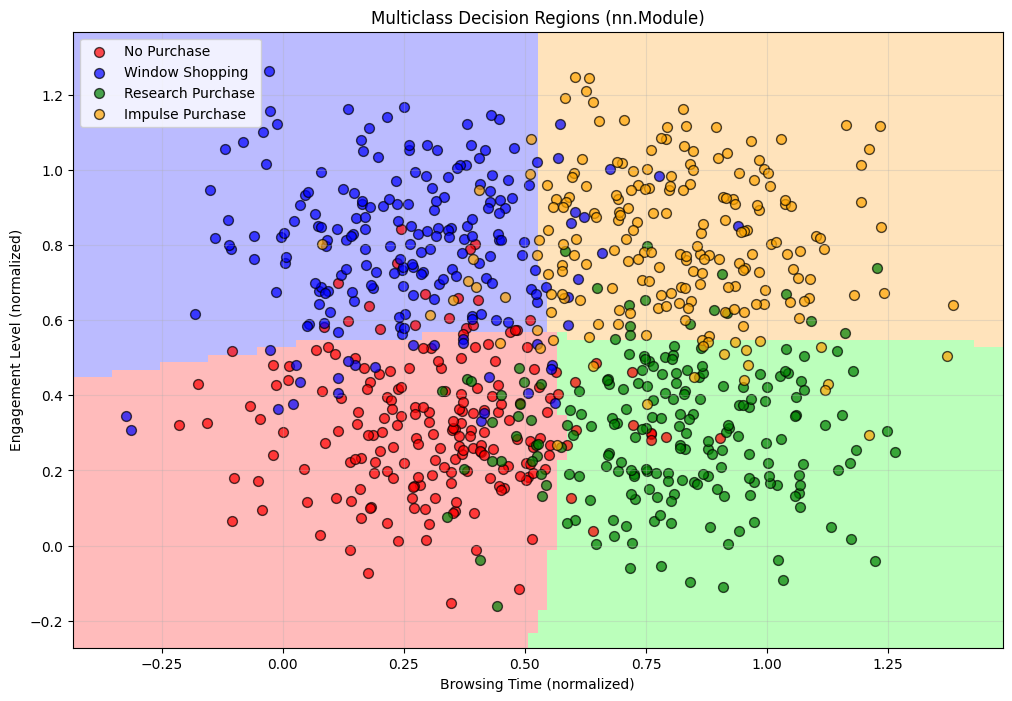

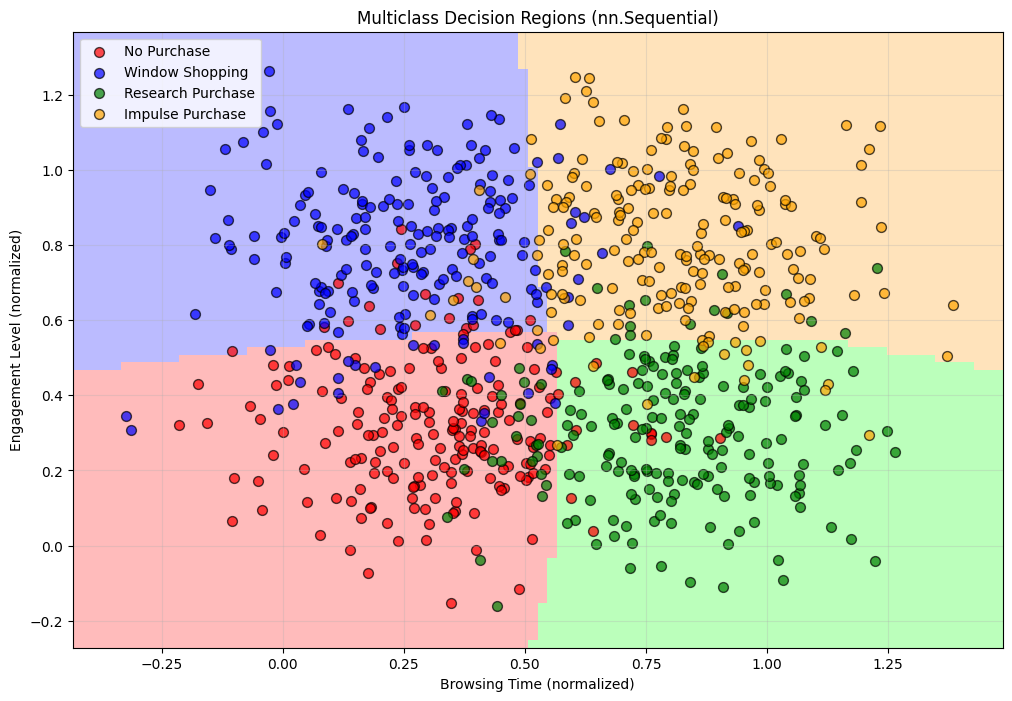

In [11]:
# =============================================================================
# Visualize Decision Boundaries
# =============================================================================

print(f"\n=== Visualizing Multiclass Decision Boundaries ===")

# Plot decision boundaries for nn.Module model
plot_multiclass_decision_regions(module_model, multiclass_dataset, 
                                'Multiclass Decision Regions (nn.Module)')  # Plot module model boundaries

# Plot decision boundaries for nn.Sequential model
plot_multiclass_decision_regions(sequential_model, multiclass_dataset, 
                                'Multiclass Decision Regions (nn.Sequential)')  # Plot sequential model boundaries


In [12]:
# =============================================================================
# Prediction Analysis and Class Probabilities
# =============================================================================

def analyze_predictions(model, dataset, num_samples=10):  # Function to analyze individual predictions
    """Analyze individual predictions and show class probabilities"""
    
    print(f"\n=== Sample Predictions Analysis ===")
    
    # Get random samples for analysis
    indices = torch.randperm(len(dataset))[:num_samples]  # Random sample indices
    
    class_names = ['No Purchase', 'Window Shopping', 'Research Purchase', 'Impulse Purchase']  # Class names
    
    with torch.no_grad():  # Disable gradients for inference
        for i, idx in enumerate(indices):  # Loop through sample indices
            features, true_label = dataset[idx]  # Get sample features and true label
            
            # Get model prediction
            logits = model(features.unsqueeze(0))  # Add batch dimension and get logits
            probabilities = F.softmax(logits, dim=1)  # Apply Softmax to get probabilities
            predicted_class = torch.argmax(logits, dim=1).item()  # Get predicted class
            
            print(f"\nSample {i+1}:")
            print(f"  Features: Time={features[0]:.3f}, Engagement={features[1]:.3f}")
            print(f"  True Class: {true_label} ({class_names[true_label]})")
            print(f"  Predicted Class: {predicted_class} ({class_names[predicted_class]})")
            print(f"  Class Probabilities:")
            for class_idx, prob in enumerate(probabilities[0]):  # Print probabilities for each class
                print(f"    {class_names[class_idx]}: {prob:.3f}")
            
            # Check if prediction is correct
            correct = "✓" if predicted_class == true_label else "✗"  # Correctness indicator
            print(f"  Prediction: {correct}")

# Analyze predictions for both models
print(f"\n--- nn.Module Model Predictions ---")
analyze_predictions(module_model, multiclass_dataset, num_samples=5)  # Analyze module model predictions

print(f"\n--- nn.Sequential Model Predictions ---")
analyze_predictions(sequential_model, multiclass_dataset, num_samples=5)  # Analyze sequential model predictions



--- nn.Module Model Predictions ---

=== Sample Predictions Analysis ===

Sample 1:
  Features: Time=0.522, Engagement=0.733
  True Class: 1 (Window Shopping)
  Predicted Class: 1 (Window Shopping)
  Class Probabilities:
    No Purchase: 0.043
    Window Shopping: 0.501
    Research Purchase: 0.033
    Impulse Purchase: 0.423
  Prediction: ✓

Sample 2:
  Features: Time=0.169, Engagement=0.472
  True Class: 0 (No Purchase)
  Predicted Class: 0 (No Purchase)
  Class Probabilities:
    No Purchase: 0.765
    Window Shopping: 0.228
    Research Purchase: 0.006
    Impulse Purchase: 0.001
  Prediction: ✓

Sample 3:
  Features: Time=1.067, Engagement=0.103
  True Class: 2 (Research Purchase)
  Predicted Class: 2 (Research Purchase)
  Class Probabilities:
    No Purchase: 0.012
    Window Shopping: 0.000
    Research Purchase: 0.986
    Impulse Purchase: 0.002
  Prediction: ✓

Sample 4:
  Features: Time=0.365, Engagement=0.265
  True Class: 0 (No Purchase)
  Predicted Class: 0 (No Purchase)


In [13]:
# =============================================================================
# Summary: Binary vs Multiclass Comparison
# =============================================================================

print(f"\n=== Summary: Binary vs Multiclass Neural Networks ===")

print(f"\nKey Differences:")
print(f"• Output Layer: Binary (1 neuron) vs Multiclass ({d_out} neurons)")
print(f"• Activation: Binary (Sigmoid) vs Multiclass (None - raw logits)")
print(f"• Loss Function: Binary (BCELoss) vs Multiclass (CrossEntropyLoss)")
print(f"• Prediction: Binary (>0.5 threshold) vs Multiclass (argmax)")

print(f"\nModel Performance:")
print(f"• nn.Module Final Accuracy: {module_accuracies[-1]:.4f}")
print(f"• nn.Sequential Final Accuracy: {sequential_accuracies[-1]:.4f}")

print(f"\nArchitecture Comparison:")
print(f"• Both approaches (nn.Module vs nn.Sequential) achieve similar performance")
print(f"• nn.Sequential is more concise for simple architectures")
print(f"• nn.Module provides more flexibility for complex architectures")

print(f"\nKey Insight: Multiclass extends binary classification by:")
print(f"1. Adding more output neurons (one per class)")
print(f"2. Using CrossEntropyLoss (includes Softmax internally)")
print(f"3. Predicting using argmax instead of threshold")
print(f"4. Enabling classification of multiple customer behavior categories!")


=== Summary: Binary vs Multiclass Neural Networks ===

Key Differences:
• Output Layer: Binary (1 neuron) vs Multiclass (4 neurons)
• Activation: Binary (Sigmoid) vs Multiclass (None - raw logits)
• Loss Function: Binary (BCELoss) vs Multiclass (CrossEntropyLoss)
• Prediction: Binary (>0.5 threshold) vs Multiclass (argmax)

Model Performance:
• nn.Module Final Accuracy: 0.7958
• nn.Sequential Final Accuracy: 0.8083

Architecture Comparison:
• Both approaches (nn.Module vs nn.Sequential) achieve similar performance
• nn.Sequential is more concise for simple architectures
• nn.Module provides more flexibility for complex architectures

Key Insight: Multiclass extends binary classification by:
1. Adding more output neurons (one per class)
2. Using CrossEntropyLoss (includes Softmax internally)
3. Predicting using argmax instead of threshold
4. Enabling classification of multiple customer behavior categories!
